In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
np.random.seed(42)
%matplotlib inline

In [90]:
omega = 2. * np.pi / (5.4 * 60.) # s^-1 ; ang freq for 5.4 minute oscillation
gamma = 1. / (2 * 24. * 60. * 60.) # s^-1 ; 2-day damping timescale
dt = 50. # seconds - approximate Nyquist sampling
driving_amp = np.sqrt(0.19**2 * gamma * dt) # kick amplitude to get 19 cm/s amplitude over coherence time

In [91]:
def step_forward_matrix(omega, gamma, dt):
    # return [x, rv] after time dt
    Minv = np.linalg.inv(np.array([[1, 0], [-0.5 * gamma, omega]]))
    A = np.array([[np.cos(omega * dt),
                   np.sin(omega * dt)],
                  [-omega * np.sin(omega * dt) - 0.5 * gamma * np.cos(omega * dt),
                    omega * np.cos(omega * dt) - 0.5 * gamma * np.sin(omega * dt)]])
    A *= np.exp(-0.5 * gamma * dt)
    return np.dot(A, Minv)

In [92]:
def take_one_step(x0, v0, step_half_matrix, step_full_matrix, driving_amp):
    # returns x0.5, v0.5 (prediction for next observation time)
    # and x1, v1 (starting position post-kick)
    x_half, v_half = np.dot(step_half_matrix, (x0,v0))
    x_one, v_one = np.dot(step_full_matrix, (x0,v0))
    v_one += driving_amp * np.random.normal(0.,1.)
    return x_half, v_half, x_one, v_one

In [119]:
def take_many_steps(omega, gamma, dt, driving_amp, timescale=365.):
    # timescale is number of days to observe
    assert dt < np.pi / omega, "ERROR: you're not well-sampled. decrease dt."
    if dt > 0.5 * np.pi / omega: print("WARNING: your coarse time spacing makes even cubic spline risky")

    ts = dt * np.arange(timescale * 24. * 3600. / dt)
    xs = np.zeros_like(ts)
    rvs = np.zeros_like(ts)
    
    step_half_matrix = step_forward_matrix(omega, gamma, 0.5 * dt)
    step_full_matrix = step_forward_matrix(omega, gamma, dt)
    x0, v0 = 0., 0.
    for i,t in enumerate(ts):
        xs[i], rvs[i], x0, v0 = take_one_step(x0, v0, step_half_matrix, step_full_matrix, driving_amp)
    return ts, xs, rvs

In [107]:
dt = 1. * 60. # 1-minute cadence
timespan = 365. # not-Kepler
ts, xs, rvs = take_many_steps(omega, gamma, dt, driving_amp, timescale=timespan)

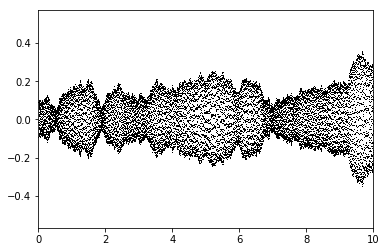

In [97]:
plt.plot(ts/86400., rvs, 'k,')
plt.xlim([0.,10.]);

Ramp-up period (only makes sense if you are initializing at exactly zero).

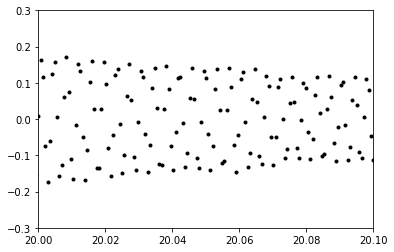

In [98]:
plt.plot(ts/86400., rvs, 'k.')
plt.xlim([20.,20.1])
plt.ylim([-0.3,0.3]);

Looks coherent over short timescales.

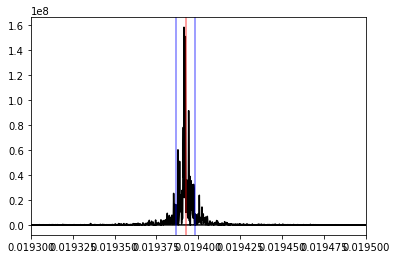

In [99]:
powers = np.fft.fft(rvs)
real_powers = (powers * powers.conj()).real
omegas = np.fft.fftfreq(rvs.shape[-1]) / dt * 2. * np.pi
plt.plot(omegas, real_powers, 'k-')
plt.xlim([0.0193,0.0195])
plt.axvline(omega, alpha=0.5, c='r')
plt.axvline(omega-gamma, alpha=0.5, c='b')
plt.axvline(omega+gamma, alpha=0.5, c='b');

Tests: turning off driving and/or damping makes the FT very clean.

Hogg says that we should not calculate this on a very fine grid because numerical issues may come into play; instead, we can generate a fine grid and use cubic spline interpolation to populate it from the coarser samples (this is fine because of the Nyquist theorem which says at our sampling we already have all the necessary info).

Test this by taking the "jagged" timeseries between 20.0-20.1 days and doing an interpolation onto a much finer grid; ideally this will look like a sinusoid.

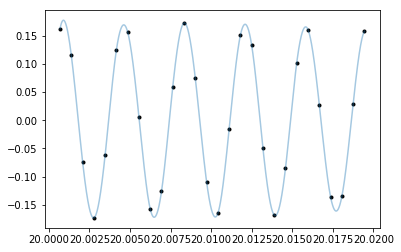

In [100]:
inds = (ts/86400. > 20.) & (ts/86400. < 20.02)
short_ts = ts[inds]
short_rvs = rvs[inds]
plt.plot(short_ts/86400., short_rvs, 'k.')
interp = interp1d(short_ts, short_rvs, kind='cubic', assume_sorted=True)
xs = np.arange(np.min(short_ts), np.max(short_ts), 0.0005)
plt.plot(xs/86400., interp(xs), alpha=0.4);

Yep!

In [161]:
def simulate_exposure(ts, rvs, start_time, exp_time):
    interp = interp1d(ts, rvs, kind='cubic', assume_sorted=True)
    tiny = 0.1 # 100 ms
    fine_ts = np.arange(start_time, start_time+exp_time, tiny) # fine grid
    fine_rvs = interp(fine_ts)
    return np.sum(fine_rvs)/len(fine_rvs) # ASSUMES EVEN WEIGHTING - technically incorrect for last point

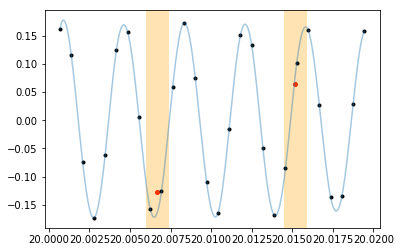

In [162]:
plt.plot(short_ts/86400., short_rvs, 'k.')
interp = interp1d(short_ts, short_rvs, kind='cubic', assume_sorted=True)
xs = np.arange(np.min(short_ts), np.max(short_ts), 0.0005)
plt.plot(xs/86400., interp(xs), alpha=0.4)
start_times = np.array([20.006, 20.0145]) * 86400. # seconds
exp_time = 120. # seconds
for st in start_times:
    plt.axvspan(st/86400., (st+exp_time)/86400., alpha=0.3, facecolor='orange')
    plt.scatter((st+exp_time/2)/86400., simulate_exposure(short_ts,short_rvs,st,exp_time),
               c='r', s=16);

Now do this for many modes (drawing from the envelope of modes & amplitudes in Chaplin paper) & co-add all RVs

NOTE: I made up the amplitude based on Chaplin figure because their given a_max didn't reproduce Figure 2. There must be something about powers and square roots that I'm getting wrong!

In [144]:
#freq_grid = 1./(np.arange(4.,8.,0.05) * 60.) # frequencies in Hz
a_max = 0.55 # amplitude of central mode in m/s
nu_max = 3.1e-3 # peak frequency in Hz
c_env = 0.331e-3 # envelope width in Hz
delta_nu = 0.00013 # Hz
freq_grid = np.arange(nu_max - 0.001, nu_max + 0.001, delta_nu) # magic numbers
amp_grid = a_max**2 * np.exp(-(freq_grid-nu_max)**2/(2.*c_env**2)) # amplitudes in m/s
driving_amp_grid = np.sqrt(amp_grid * gamma * dt)

In [156]:
l_grid = np.append(np.zeros_like(freq_grid), np.ones_like(freq_grid))
freq_grid = np.append(freq_grid, freq_grid)
freq_grid += l_grid * 0.5 * delta_nu # Hogg!
omega_grid = 2.*np.pi*freq_grid # angular frequencies
amp_grid = a_max**2 * np.exp(-(freq_grid-nu_max)**2/(2.*c_env**2)) # amplitudes in m/s
amp_grid -= 0.4 * amp_grid * l_grid # Hogg!
driving_amp_grid = np.sqrt(amp_grid * gamma * dt)

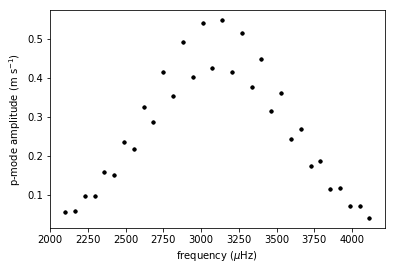

In [147]:
plt.plot(freq_grid * 1.e6, np.sqrt(amp_grid), 'k.')
plt.ylabel('p-mode amplitude (m s$^{-1}$)')
plt.xlabel('frequency ($\mu$Hz)');

In [152]:
from tqdm import tqdm

dt = 1. * 60. # 1-minute cadence
timespan = 365. # a year

ts = None
xs = np.zeros_like(ts)
rvs = np.zeros_like(ts)
for omega, driving_amp in tqdm(zip(omega_grid,driving_amp_grid)):
    sim = take_many_steps(omega, gamma, dt, driving_amp, timescale=timespan)
    if ts is None: ts = sim[0]
    assert np.array_equal(sim[0], ts)
    xs += sim[1]
    rvs += sim[2]

64it [05:43,  5.36s/it]


Same simulation for just the strongest mode:

In [160]:
I = np.argmax(driving_amp_grid)
sim = take_many_steps(omega_grid[I], gamma, dt, driving_amp_grid[I], timescale=timespan)
ts_onemode, xs_onemode, rvs_onemode = sim

1.7230769755477964

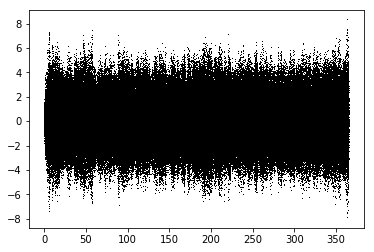

In [153]:
plt.plot(ts/86400., rvs, 'k,')
#plt.xlim([0.,10.]);
#plt.ylim([-0.5,0.5]);
np.std(rvs)

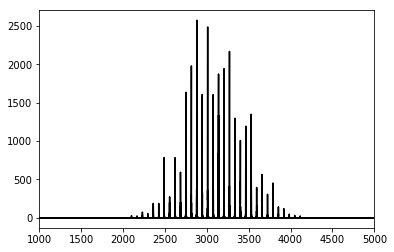

In [155]:
powers = np.fft.fft(rvs)
real_powers = (powers * powers.conj()).real
fs = np.fft.fftfreq(rvs.shape[-1]) / dt
plt.plot(fs*1e6, real_powers/1e6, 'k-')
plt.xlim([1000,5000]);
#plt.xlim([0.,0.03]);

Simulate some exposure times (over a month of nightly observations) and see what the RMS is!

Note: in this case we are neglecting any sources of noise. If we were to add in photon noise then we'd probably want to compensate with more exposures per night for the shorter exposure times such that the effective SNR is the same for all cases.

In [167]:
obs_ts = np.arange(30) + 0.5 + np.random.normal(0.,2.,30)/3600. # nightly plus/minus ~2 hours (days)
obs_ts *= 24. * 3600. # seconds
exp_times = np.arange(2,20,0.5) * 60.
stds = []
for exp_time in tqdm(exp_times):
    obs_rvs = [simulate_exposure(ts_onemode, rvs_onemode, tt-exp_time/2., exp_time) for tt in obs_ts]
    stds.append(np.std(obs_rvs))

100%|██████████| 36/36 [02:40<00:00,  4.46s/it]


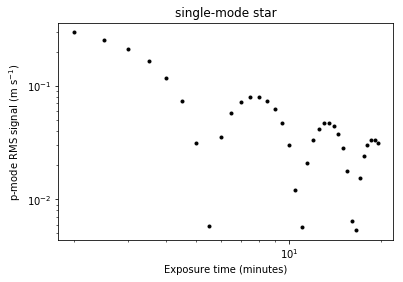

In [173]:
plt.loglog(exp_times/60., stds, 'k.')
plt.xlabel('Exposure time (minutes)')
plt.ylabel('p-mode RMS signal (m s$^{-1}$)')
plt.title('single-mode star');

As expected, for a single mode you really can reduce the p-mode signal by orders of magnitude if you expose at the characteristic period of that mode.

In [169]:
stds_all = []
for exp_time in tqdm(exp_times):
    obs_rvs = [simulate_exposure(ts, rvs, tt-exp_time/2., exp_time) for tt in obs_ts]
    stds_all.append(np.std(obs_rvs))

100%|██████████| 36/36 [02:42<00:00,  4.53s/it]


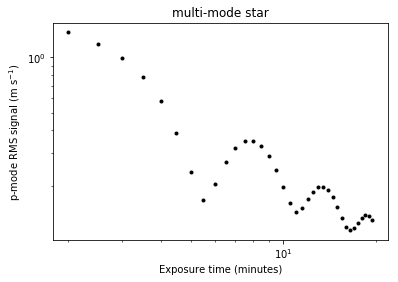

In [172]:
plt.loglog(exp_times/60., stds_all, 'k.')
plt.xlabel('Exposure time (minutes)')
plt.ylabel('p-mode RMS signal (m s$^{-1}$)')
plt.title('multi-mode star');

This looks a lot like the Chaplin results! Yay!